In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import os

try:
    os.chdir("/Users/eylul/Desktop/all_images")
    print("Yeni Dizin:", os.getcwd())

except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")

Yeni Dizin: /Users/eylul/Desktop/all_images


In [5]:

import os

image_dir = "/Users/eylul/Desktop/all_images"

print("all_images var mı?:", os.path.exists(image_dir))
print("Toplam görüntü sayısı:", len(os.listdir(image_dir)))

all_images var mı?: True
Toplam görüntü sayısı: 10019


In [6]:
import csv
import os

metadata_file = "/Users/eylul/Desktop/all_images/HAM10000_metadata.csv"
metadata = []

print("Dosya var mı?", os.path.exists(metadata_file))

with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

Dosya var mı? True
Metadata yüklendi. Toplam satır: 10015


In [7]:
dst_dir = "/Users/eylul/Desktop/all_images"

label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")

    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 10015


In [8]:
import random


class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = int(n * 0.15)
    val_n = int(n * 0.15)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])


random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 7017, Val: 1499, Test: 1499


In [9]:
from torchvision import transforms

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

data_dir = "/Users/eylul/Desktop/archive/splitted"
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 7

print("Veri yolu:", data_dir)
print("Batch size:", batch_size)
print("Epoch sayısı:", num_epochs)
print("Learning rate:", learning_rate)
print("Sınıf sayısı:", num_classes)

Veri yolu: /Users/eylul/Desktop/archive/splitted
Batch size: 8
Epoch sayısı: 10
Learning rate: 0.001
Sınıf sayısı: 7


In [11]:
from torch.utils.data import Dataset

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        from PIL import Image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
import csv
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# DOĞRU dosya ve resim klasörü yolları
csv_file = "/Users/eylul/Desktop/all_images/HAM10000_metadata.csv"
image_dir = "/Users/eylul/Desktop/all_images"

# CSV’den veriyi oku ve tam resim yolunu oluştur
data_list = []
with open(csv_file, newline='', encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image_filename = row['image_id'] + ".jpg"
        image_path = os.path.join(image_dir, image_filename)
        label = row['dx']
        data_list.append({
            'image_path': image_path,
            'label': label
        })

print("Toplam veri:", len(data_list))

#Train / Validation / Test bölme
train_list, temp_list = train_test_split(
    data_list,
    test_size=0.3,
    random_state=42,
    stratify=[d['label'] for d in data_list]
)

val_list, test_list = train_test_split(
    temp_list,
    test_size=0.5,
    random_state=42,
    stratify=[d['label'] for d in temp_list]
)

print("Train:", len(train_list), "Val:", len(val_list), "Test:", len(test_list))

# Dataset sınıfı
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = Image.open(item['image_path']).convert("RGB")
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

#Transformlar
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

#Dataset & DataLoader
train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader hazır!")


Toplam veri: 10015
Train: 7010 Val: 1502 Test: 1503
DataLoader hazır!


In [22]:
import torch
from torchvision.models import resnet101
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet101(weights=None)

# 🔒 TÜM AĞI DONDUR
for param in model.parameters():
    param.requires_grad = False

# 🔄 FC KATMANINI DEĞİŞTİR
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

In [23]:
# 🔒 Tüm ağı dondur
for param in model.parameters():
    param.requires_grad = False

# 🔓 Sadece FC katmanı açık
for param in model.fc.parameters():
    param.requires_grad = True

In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),  # sadece FC eğitilecek
    lr=1e-4
)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet101

# =========================
# DEVICE
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# MODEL
# =========================
model = resnet101(pretrained=False)  # ağırlık indirme sorunu yok

# TÜM AĞI DONDUR
for param in model.parameters():
    param.requires_grad = False

# FC KATMANINI DEĞİŞTİR
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# =========================
# LOSS & OPTIMIZER
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# =========================
# TRAINING
# =========================
num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} başladı")

    # 🔥 KRİTİK: eval modu (BatchNorm donmaması için)
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # -------- TRAIN --------
    for images, labels in train_loader:
        images = images.to(device)
        labels = torch.tensor(
            [label_map[l] for l in labels],
            dtype=torch.long
        ).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # -------- VALIDATION --------
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = torch.tensor(
                [label_map[l] for l in labels],
                dtype=torch.long
            ).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(running_loss / len(val_loader))
    val_accs.append(correct / total)

    print(
        f"Train Acc: {train_accs[-1]:.3f} | "
        f"Val Acc: {val_accs[-1]:.3f}"
    )

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/10 başladı
Train Acc: 0.478 | Val Acc: 0.668

Epoch 2/10 başladı
Train Acc: 0.487 | Val Acc: 0.670

Epoch 3/10 başladı
Train Acc: 0.490 | Val Acc: 0.128

Epoch 4/10 başladı
Train Acc: 0.494 | Val Acc: 0.185

Epoch 5/10 başladı
Train Acc: 0.492 | Val Acc: 0.336

Epoch 6/10 başladı
Train Acc: 0.481 | Val Acc: 0.646

Epoch 7/10 başladı
Train Acc: 0.487 | Val Acc: 0.666

Epoch 8/10 başladı
Train Acc: 0.487 | Val Acc: 0.670

Epoch 9/10 başladı
Train Acc: 0.492 | Val Acc: 0.670

Epoch 10/10 başladı
Train Acc: 0.491 | Val Acc: 0.670


In [27]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()

all_preds = []
all_labels = []
all_probs = [] # Olasılıkları saklamak için

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        labels = torch.tensor(
            [label_map[l] for l in labels],
            dtype=torch.long
        ).to(device)

        outputs = model(images)
        
        # Olasılıkları hesapla
        probs = F.softmax(outputs, dim=1)
        
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ROC-AUC Hesaplama
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"✅ ResNet test tamamlandı")
print(f"📊 ResNet101 ROC-AUC Skoru: {roc_auc:.4f}")

✅ ResNet test tamamlandı
📊 ResNet101 ROC-AUC Skoru: 0.5000


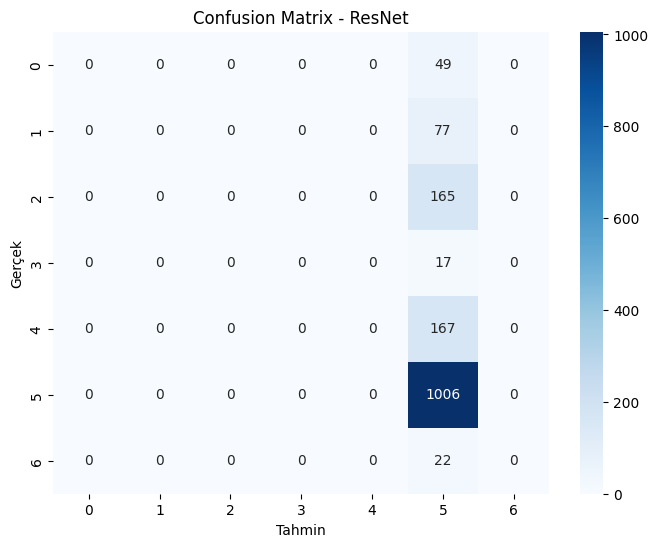

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00       165
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00       167
           5       0.67      1.00      0.80      1006
           6       0.00      0.00      0.00        22

    accuracy                           0.67      1503
   macro avg       0.10      0.14      0.11      1503
weighted avg       0.45      0.67      0.54      1503



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix - ResNet")
plt.show()

print(classification_report(all_labels, all_preds, zero_division=0))

In [29]:
inv_label_map = {v: k for k, v in label_map.items()}

In [32]:
# Sınıfları benign / malignant olarak gruplama
cancer_map = {
    "akiec": "Malignant",
    "bcc": "Malignant",
    "bkl": "Benign",
    "df": "Benign",
    "mel": "Malignant",
    "nv": "Benign",
    "vasc": "Benign"
}

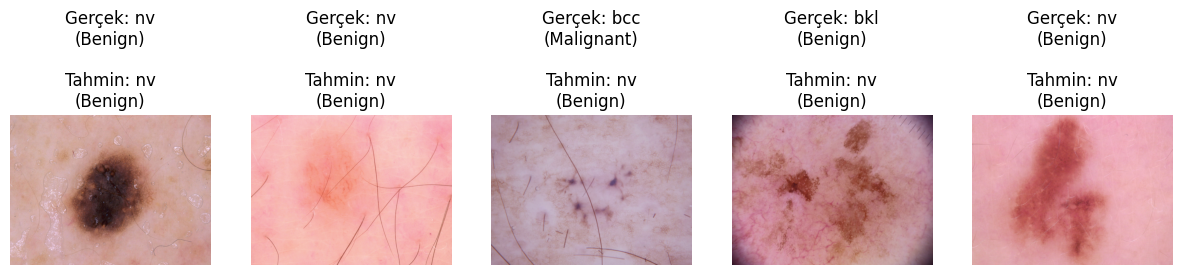

In [33]:
import random
from PIL import Image
import matplotlib.pyplot as plt

model.eval()

# 5 rastgele test örneği
sample_items = random.sample(test_list, 5)

plt.figure(figsize=(15,5))

for i, item in enumerate(sample_items):
    img_path = item["image_path"]
    true_class = item["label"]   # 'mel', 'nv', vs.

    image = Image.open(img_path).convert("RGB")
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()

    pred_class = inv_label_map[pred_idx]

    true_cancer = cancer_map[true_class]
    pred_cancer = cancer_map[pred_class]

    plt.subplot(1,5,i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Gerçek: {true_class}\n({true_cancer})\n\n"
        f"Tahmin: {pred_class}\n({pred_cancer})"
    )

plt.show()